### Hermite-Gaussian Retreival

In this example, we will do a simple standalone demonstration recovering a (truncated)
Hermite-Gaussian Mode using `phastphase`. This example requires `scipy` in addition to 
`phastphase` dependencies.

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import scipy
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.getcwd(), '../../phastphase'))
import phastphase


In [2]:
if torch.cuda.is_available():
    tensor_device = torch.device('cuda')
else:
    tensor_device = torch.device('cpu')

We start by establishing the coordinate system, and creating the Gauss-Hermite (3,3) mode, with an added roating phase to make the problem more interesting. 

In [3]:
# Set up number of sample points, and oversampling for the DFT
n_pts = 2**8
oversample_factor = 2
herm_gauss_ord = 3

# Define the coordinate system, we will truncate the Hermite-Gauss modes
x_bound = 1.4
y_bound = 1.4
x = np.linspace(-x_bound, x_bound, n_pts)
y = np.linspace(-y_bound, y_bound, n_pts)
x,y = np.meshgrid(x, y)
r = np.sqrt((x+x_bound)**2+(y+y_bound)**2)

# Create the Hermite-Gauss modes
herm_gauss_beam = (
    special.eval_hermite(herm_gauss_ord, np.sqrt(2)*x) *
    special.eval_hermite(herm_gauss_ord, np.sqrt(2)*y) *
    np.exp(-(x**2 + y**2))
)

# Add a vortex phase to make this example more interesting
herm_gauss_beam = herm_gauss_beam * np.exp(3j*np.arctan2(x,y))

Let's make a helper function to look at the magnitude and phase profiles of the complex result.

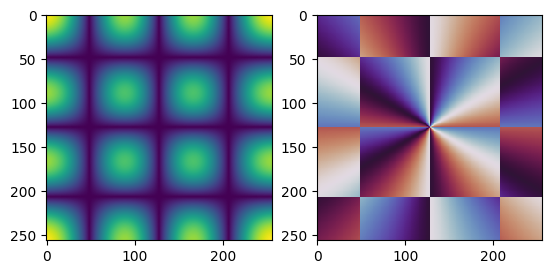

In [4]:
def plot_mag_phase(complex_image):
    _, axs = plt.subplots(1,2)
    axs[0].imshow(np.abs(complex_image), cmap="Blues")
    axs[1].imshow(np.angle(complex_image),cmap="twilight", interpolation="none")
    plt.show()

plot_mag_phase(herm_gauss_beam)

Without nearfield information, phastphase only (verifiably) works on Schwarz objects,
which are objects with power concentrated in a bright spot in the nearfield. 
To make this Hermite-Gauss beam Schwarz, we will apply a moderate exponential
decrease along each axis.

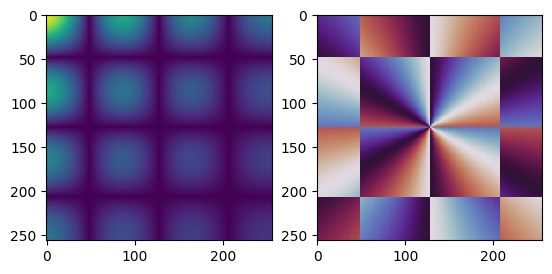

In [5]:
beam_1 = herm_gauss_beam * np.exp(-(x+x_bound)/3) * np.exp(-(y+y_bound)/3)

plot_mag_phase(beam_1)

We then move the data over to torch, and find the farfield intensity pattern

In [6]:
nearfield = torch.tensor(beam_1, device=tensor_device)
nearfield /= torch.exp(1j*torch.angle(nearfield[0,0]))
farfield = torch.square(torch.abs(torch.fft.fftn(nearfield, (oversample_factor*n_pts, oversample_factor*n_pts), norm='ortho')))

We are now ready to retrieve the nearfield using `phastphase.retrieve()`. The input will be the farfield intensities, along with the support.

In [7]:
reconstruction = phastphase.retrieve(
    farfield,
    [n_pts,n_pts],
    reference_point=[0,0]
)

Plotting the resulting reconstructed nearfield, we find a qualitatively identical
result.

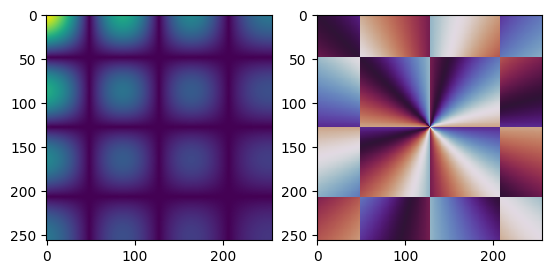

In [8]:
plot_mag_phase(reconstruction)

There is one issue, however, this reconstruction includes a relative phase, apparent as
a rotation of the 'pinwheel' of the vortex phase.
We ignore the relative phase with knowledge of where we set the initial nearfield to be
fully real.
Printing the relative squared error of the retrieved near field compared to the ground truth reveals a successful recovery!

In [9]:
reconstruction /= torch.exp(1j * torch.angle(reconstruction[0,0]))
err = (torch.linalg.vector_norm(reconstruction-nearfield)/torch.linalg.vector_norm(nearfield)).item()
print(f'Reconstruction Relative Squared Error is {err:.0e}')

Reconstruction Relative Squared Error is 6e-12


Let's try an object with a much weaker exponential decrease, mathematically "less Schwarz":

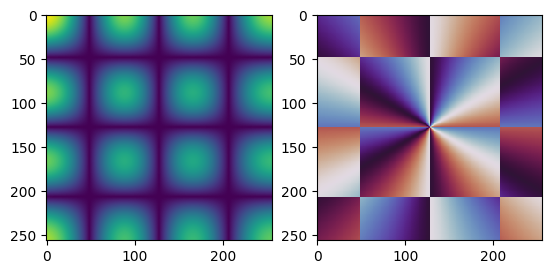

In [10]:
beam_2 = herm_gauss_beam * np.exp(-(x+x_bound)/20) * np.exp(-(y+y_bound)/20)
plot_mag_phase(beam_2)

In [11]:
nearfield = torch.tensor(beam_2,device=tensor_device)
nearfield /= torch.exp(1j*torch.angle(nearfield[0,0]))
farfield = torch.square(torch.abs(torch.fft.fftn(nearfield, (oversample_factor*n_pts, oversample_factor*n_pts), norm='ortho')))

Vanilla `phastphase` will have some trouble with this object:

In [14]:
reconstruction = phastphase.retrieve(
    farfield,
    [n_pts,n_pts],
    reference_point=[0,0]
)
reconstruction /= torch.exp(1j*torch.angle(reconstruction[0,0]))
err = (torch.linalg.vector_norm(reconstruction-nearfield)/torch.linalg.vector_norm(nearfield)).item()
print(f'Reconstruction Relative Squared Error is {err:.0e}')

Reconstruction Relative Squared Error is 1e+00


But we can help by giving it known nearfield amplitudes:

In [13]:
reconstruction = phastphase.retrieve(
    farfield,
    [n_pts,n_pts],
    reference_point=[0,0],
    known_nearfield_amp=torch.abs(nearfield)    # This line is new!
)
reconstruction /= torch.exp(1j*torch.angle(reconstruction[0,0]))
err = (torch.linalg.vector_norm(reconstruction-nearfield)/torch.linalg.vector_norm(nearfield)).item()
print(f'Reconstruction Relative Squared Error is {err:.0e}')

Reconstruction Relative Squared Error is 8e-11


In practice, the source distribution of a nearfield is often known, being the measurable
profile of an electron or optical beam.